In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('../data/Fraud_Data_processed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Positive class ratio: {df['class'].mean():.4f}")


Dataset shape: (151112, 23)
Columns: ['user_id', 'purchase_time', 'signup_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'ip_int', 'country', 'hour_of_day', 'day_of_week', 'time_since_signup', 'prev_purchase_time', 'time_since_prev_purchase', 'ip_address_numeric', 'transaction_count_24h', 'total_transactions', 'avg_purchase_value', 'unique_devices']
Positive class ratio: 0.0936


In [59]:
# Define target and features
target = 'class'  # change if different for creditcard dataset

X = df.drop(columns=[target])
y = df[target]

# Stratified split (to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Positive class ratio in train: {y_train.mean():.4f}")
print(f"Positive class ratio in test: {y_test.mean():.4f}")


Train size: 120889, Test size: 30223
Positive class ratio in train: 0.0936
Positive class ratio in test: 0.0936


In [73]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack, csr_matrix

def preprocess(df, fit_imputer=None, fit_scaler=None, fit_ohe=None):
    df = df.copy()
    
    cat_cols = ['device_id', 'source', 'browser', 'sex', 'country']
    cat_cols = [col for col in cat_cols if col in df.columns]
    
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [col for col in num_cols if col not in cat_cols]
    
    fully_missing_num_cols = [col for col in num_cols if df[col].isnull().all()]
    if fully_missing_num_cols:
        print(f"Numeric columns fully missing and dropped before imputation: {fully_missing_num_cols}")
        df = df.drop(columns=fully_missing_num_cols)
        num_cols = [col for col in num_cols if col not in fully_missing_num_cols]
    
    if fit_imputer is None:
        imputer = SimpleImputer(strategy='median')
        df[num_cols] = imputer.fit_transform(df[num_cols])
    else:
        imputer = fit_imputer
        df[num_cols] = imputer.transform(df[num_cols])
    
    for col in cat_cols:
        df[col] = df[col].fillna('missing')
    
    if fit_ohe is None:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
        ohe_matrix = ohe.fit_transform(df[cat_cols])
    else:
        ohe = fit_ohe
        ohe_matrix = ohe.transform(df[cat_cols])
    
    if fit_scaler is None:
        scaler = StandardScaler()
        scaled_numeric = scaler.fit_transform(df[num_cols])
    else:
        scaler = fit_scaler
        scaled_numeric = scaler.transform(df[num_cols])
    
    numeric_sparse = csr_matrix(scaled_numeric)
    
    X_processed = hstack([numeric_sparse, ohe_matrix], format='csr')
    
    if fit_imputer is None and fit_scaler is None and fit_ohe is None:
        return X_processed, imputer, scaler, ohe
    else:
        return X_processed


In [75]:
# First call fits imputers, scalers, encoder and transforms
X_train_processed, imputer, scaler, ohe = preprocess(X_train)

# Transform test set using fitted transformers
X_test_processed = preprocess(X_test, fit_imputer=imputer, fit_scaler=scaler, fit_ohe=ohe)

print(f"Processed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")


Numeric columns fully missing and dropped before imputation: ['prev_purchase_time', 'time_since_prev_purchase']
Numeric columns fully missing and dropped before imputation: ['prev_purchase_time', 'time_since_prev_purchase']
Processed train shape: (120889, 111594)
Processed test shape: (30223, 111594)



--- Logistic Regression Evaluation ---
Average Precision (AUC-PR): 0.5029
F1 Score: 0.3529
Confusion Matrix:
[[12  7]
 [15  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.63      0.52        19
           1       0.46      0.29      0.35        21

    accuracy                           0.45        40
   macro avg       0.45      0.46      0.44        40
weighted avg       0.45      0.45      0.43        40



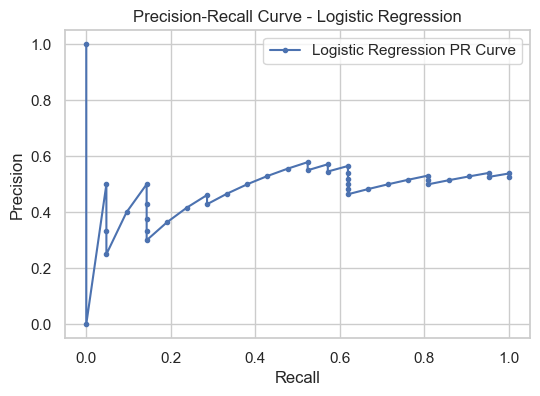

In [78]:
# Required imports
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Define the evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities and classes
    y_probs = model.predict_proba(X_test)[:, 1]
    y_preds = model.predict(X_test)
    
    # Calculate metrics
    avg_precision = average_precision_score(y_test, y_probs)
    f1 = f1_score(y_test, y_preds)
    cm = confusion_matrix(y_test, y_preds)
    
    # Print results
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Average Precision (AUC-PR): {avg_precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_preds))
    
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.', label=f'{model_name} PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Dummy data to test the function
np.random.seed(0)
X_train = np.random.rand(100, 5)
y_train = np.random.randint(0, 2, 100)
X_test = np.random.rand(40, 5)
y_test = np.random.randint(0, 2, 40)

# Instantiate model
lr = LogisticRegression()

# Call the evaluation function
evaluate_model(lr, X_train, y_train, X_test, y_test, "Logistic Regression")



--- Logistic Regression Evaluation ---
Average Precision (AUC-PR): 0.6260
F1 Score: 0.6592
Confusion Matrix:
[[26940   453]
 [ 1216  1614]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27393
           1       0.78      0.57      0.66      2830

    accuracy                           0.94     30223
   macro avg       0.87      0.78      0.81     30223
weighted avg       0.94      0.94      0.94     30223



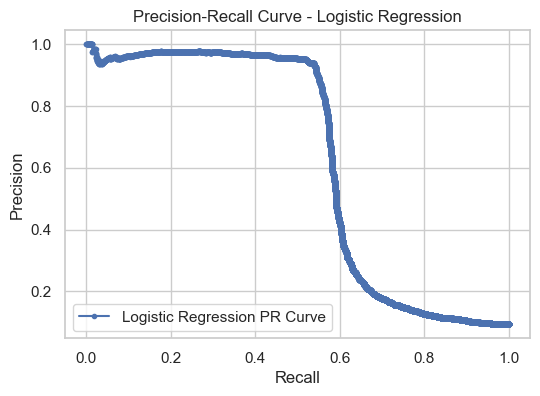

In [77]:
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
evaluate_model(lr, X_train_processed, y_train, X_test_processed, y_test, "Logistic Regression")


In [81]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['class'])  # features
y = df['class']                 # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)  # Should print (120889, <num_features>), (120889,)
print(X_test.shape, y_test.shape)    # Should print (30223, <num_features>), (30223,)


(120889, 22) (120889,)
(30223, 22) (30223,)


In [82]:
X_train_processed, imputer, scaler, ohe = preprocess(X_train)
X_test_processed = preprocess(X_test, fit_imputer=imputer, fit_scaler=scaler, fit_ohe=ohe)


Numeric columns fully missing and dropped before imputation: ['prev_purchase_time', 'time_since_prev_purchase']
Numeric columns fully missing and dropped before imputation: ['prev_purchase_time', 'time_since_prev_purchase']



--- Random Forest Evaluation ---
Average Precision (AUC-PR): 0.6278
F1 Score: 0.7003
Confusion Matrix:
[[27385     8]
 [ 1301  1529]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.54      0.70      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



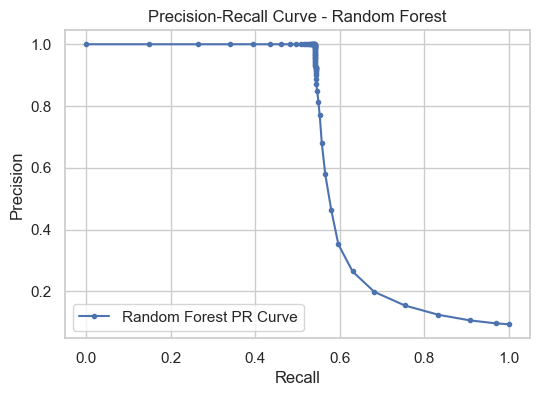

In [83]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
evaluate_model(rf, X_train_processed, y_train, X_test_processed, y_test, "Random Forest")
